# Zaitsev Anton | Exercise 4

## General Information

In this exercise we will further analyze the Twitter network (**Group 8**). Namely, we will calculate centrailiy measures, such as betweenness closeness and PageRank, and similarity measures between the node that have the highest betweenness closeness value and the rest of the nodes in the network. Additionally, we will plot the largest SCC of the Twitter network.

In [7]:
# imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [8]:
# global variables
DATA_FOLDER = "../data/"

In [9]:
# utilities
def construct_graph(edges_path: str, directed: bool = False) -> nx.Graph:
    """
    Construct a graph from an edge list.

    Parameters:
        - edges_path (str): The path to the .edges file, which contains the edges of the graph.
        - directed (bool): If True, the graph will be treated as directed, creating a NetworkX DiGraph.
    
    Returns:
        - g (nx.Graph or nx.DiGraph): A NetworkX graph containing all the nodes and edges from the .edges file.
                                      Additionally, nodes present in the .feat file but missing in the .edges
                                      file will be added to the graph as disconnected nodes (without any edges).
    """
    # read graph from .edges file
    if directed:
        g = nx.read_edgelist(edges_path, create_using=nx.DiGraph(), nodetype=int)
    else:
        g = nx.read_edgelist(edges_path, create_using=nx.Graph(), nodetype=int)
    return g

In [10]:
# load twitter network, directed graph
G_tw = construct_graph(edges_path=f"{DATA_FOLDER}3253671.edges", directed=True)

## Questions **a** and **b**

In [22]:
def calculate_betweenness(graph: nx.Graph) -> dict:
    """
    Calculates the normalized betweenness closeness values for nodes in the given graph.

    Parameters:
        - graph (nx.Graph): Input graph.
    
    Returns:
        - betweenness (dict): Betweenness closeness values.
    """
    betweenness = nx.betweenness_centrality(G=graph, normalized=True)
    return betweenness

def calculate_pagerank(graph: nx.Graph, alpha=0.85) -> dict:
    """
    Calculates the PageRank values for nodes in the given graph.

    Parameters:
        - graph (nx.Graph): Input graph.
        - alpha (float): Damping parameter for PageRank.
    
    Returns:
        - pagerank (dict): Pagerank scores.
    """
    pagerank = nx.pagerank(G=graph, alpha=alpha)
    return pagerank

def plot_betweenness_pagerank(graph: nx.Graph, betweenness: dict, pagerank: dict) -> None:
    """
    Plots Betweenness Closeness and PageRank values assossiated with the same nodes.

    Parameters:
        - graph (nx.Graph): Input graph.
        - betweenness (dict): Betweenness closeness values.
        - pagerank (dict): Pagerank scores.
    """
    # get node ids
    common_keys = list(set(betweenness.keys()).intersection(set(pagerank.keys())))
    # extract values corresponding to the same nodes
    betweenness_values = [betweenness[k] for k in common_keys]
    pagerank_values = [pagerank[k] for k in common_keys]
    # compute trend line between betweenness and PageRank
    z = np.polyfit(betweenness_values, pagerank_values, 1)  # linear fit (degree 1)
    p = np.poly1d(z)
    # betweenness
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(betweenness_values, pagerank_values, color="#125b9a")
    # add the trend line to the plot
    plt.plot(betweenness_values, p(betweenness_values), color="#8c1f53", label="Trend Line")
    plt.xlabel("Betweenness", fontsize=10)
    plt.ylabel("PageRank", fontsize=10)
    plt.title("Comparison of Betweenness Closeness and PageRank, Twitter", fontsize=12, fontweight="bold")
    plt.legend()
    # graph
    plt.subplot(1, 2, 2)
    pos = nx.spring_layout(graph, k=1)  # spring layout for better visualization of graph structure
    nx.draw(graph, pos, with_labels=False, node_size=100, node_color="#125b9a", edge_color="gray", font_size=18, alpha=0.7)
    plt.title("Network Graph", fontweight="bold")
    # plotting
    plt.tight_layout()
    plt.show()

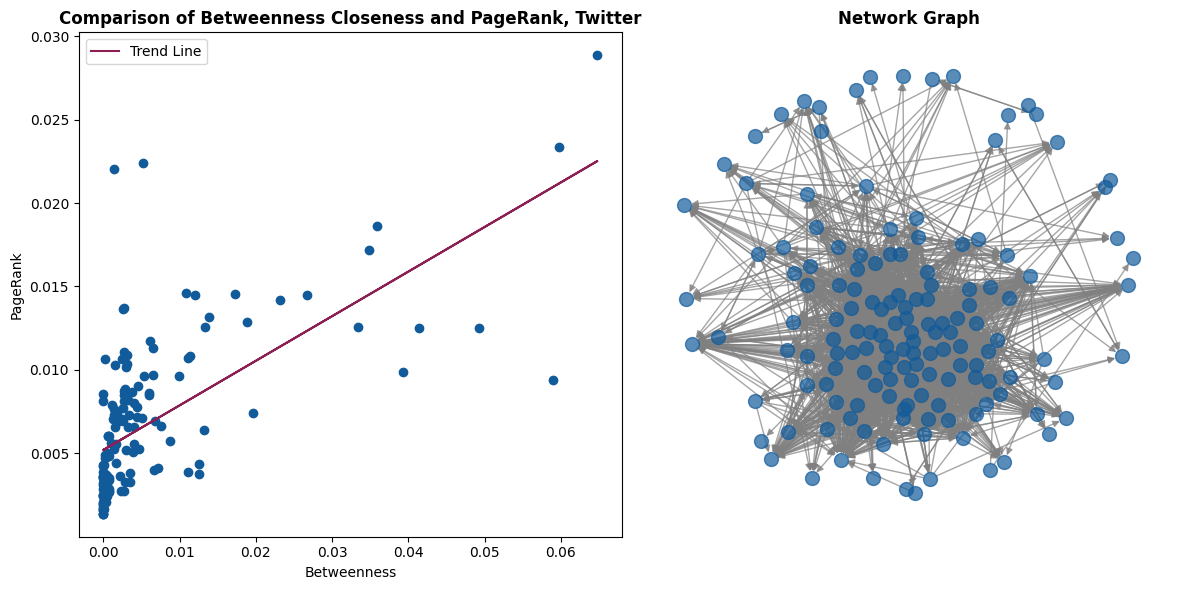

In [23]:
tw_betweenness = calculate_betweenness(graph=G_tw)
tw_pagerank = calculate_pagerank(graph=G_tw)
plot_betweenness_pagerank(graph=G_tw, betweenness=tw_betweenness, pagerank=tw_pagerank)

**Betweenness Closeness** measures how much the node plays the **role of a bridge**. Whereas **Pagerank** score of a node corresponds to the **probability** **of** a **random walker to be on this node after an infinite number of hops**. So, these two measures are different in nature, which explains the difference in values between them. In simple terms, **Betweenness** identifies **connectors**, while **PageRank** identifies **influencers**. Thus, their values should not correlate strongly. From the `Comparison of Betweenness and PageRank, Twitter` graph we can observe the following interesting trends:
1. Initially, the growth of PageRank values appears to be independent of Betweenness. PageRank increases to around $0.015$ and even reaches values close to $0.023$, while Betweenness remains in the range of $0.00−0.01$. In the context of the Twitter network, this suggests that a user can be highly influential (high PageRank) without acting as a significant connector between communities, which explains the consistently low Betweenness.
2. As Betweenness increases, PageRank tends to stagnate around $0.015$ or even decrease. This interesting observation implies that while bridge nodes (with higher Betweenness) may play an important role in connecting different parts of the network, they are not necessarily the most influential users in terms of PageRank.
3. So, even though the trend line appears to be increasing, meaning there exists positive correlation between **Betweenness Closeness** and **Pagerank**, that is not necessarily true. We need more nodes to make a more concrete conclusion.

## Question **c**

In [13]:
def plot_graph(graph: nx.Graph) -> None:
    """
    Plots a structure of a given graph.
    """
    pos = nx.spring_layout(graph, k=1)  # spring layout for better visualization of graph structure
    nx.draw(graph, pos, with_labels=False, node_size=100, node_color="#125b9a", edge_color="gray", font_size=18, alpha=0.7)
    plt.title("Graph of the Largest SCC in Twitter", fontweight="bold")
    plt.plot()

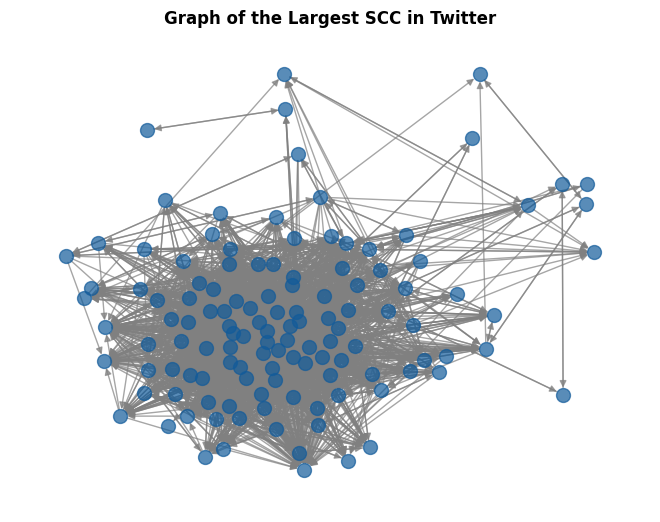

In [14]:
# retrieve the nodes that make up the largest SCC in Twitter
largest_scc_tw_nodes = max(nx.strongly_connected_components(G_tw), key=len)
# get the subgraph of the Twitter network that contains all nodes in the largest SCC
largest_scc_tw = G_tw.subgraph(largest_scc_tw_nodes).copy()
# plot the subgraph of the largest SCC
plot_graph(graph=largest_scc_tw)

## Question **d**

Here we will work with a node that has the highest **Betweenness Closeness** value and compute Jaccard similarity, cosine similarity and normalized Euclidean distance between this node and the rest of the nodes in the graph.

In [15]:
def compute_jaccard_similarity(graph: nx.Graph, node: int) -> list:
    # convert to undirected graph
    graph_undirected = graph.to_undirected()
    # extract all pairs (ebunch) that contain the given node
    ebunch = [(node, other_node) for other_node in graph_undirected.nodes() if other_node != node]
    # compute jaccard similarity
    jaccard_sim = list(nx.jaccard_coefficient(graph_undirected, ebunch))
    # return only similarity scores
    return np.array(jaccard_sim)[:, -1]

def compute_cosine_similarity(graph: nx.Graph, node: int) -> list:
    # get the adjacency matrix
    adj_matrix = nx.adjacency_matrix(graph).todense()
    # find the adjacency vector of the given node
    node_list = list(graph.nodes())
    node_index = node_list.index(node)
    adj_node = adj_matrix[node_index]
    # expand dimensions to make shapes compatible for the cosine_similarity operation
    adj_node_expanded = np.expand_dims(adj_node, axis=0)
    # compute cosine similarity between the node and all other nodes in the graph
    cosine_sim = cosine_similarity(adj_node_expanded, adj_matrix)[0]
    # remove similarity score between node and itself (it's 1) and return similarity scores
    return np.delete(cosine_sim, node_index)

def compute_euclidean_distance(graph: nx.Graph, node: int) -> list:
    # get the adjacency matrix
    adj_matrix = nx.adjacency_matrix(graph).todense()
    # find the adjacency vector of the given node
    node_list = list(graph.nodes())
    node_index = node_list.index(node)
    adj_node = adj_matrix[node_index]
    # expand dimensions to make shapes compatible for the euclidean_distances operation
    adj_node_expanded = np.expand_dims(adj_node, axis=0)
    # compute eucledian distances between all the adjancency vectors
    euclidean_dists = euclidean_distances(adj_matrix, adj_node_expanded, squared=True)
    # remove distance between node and itself (it's 0) and return the distances
    return np.delete(euclidean_dists, node_index)

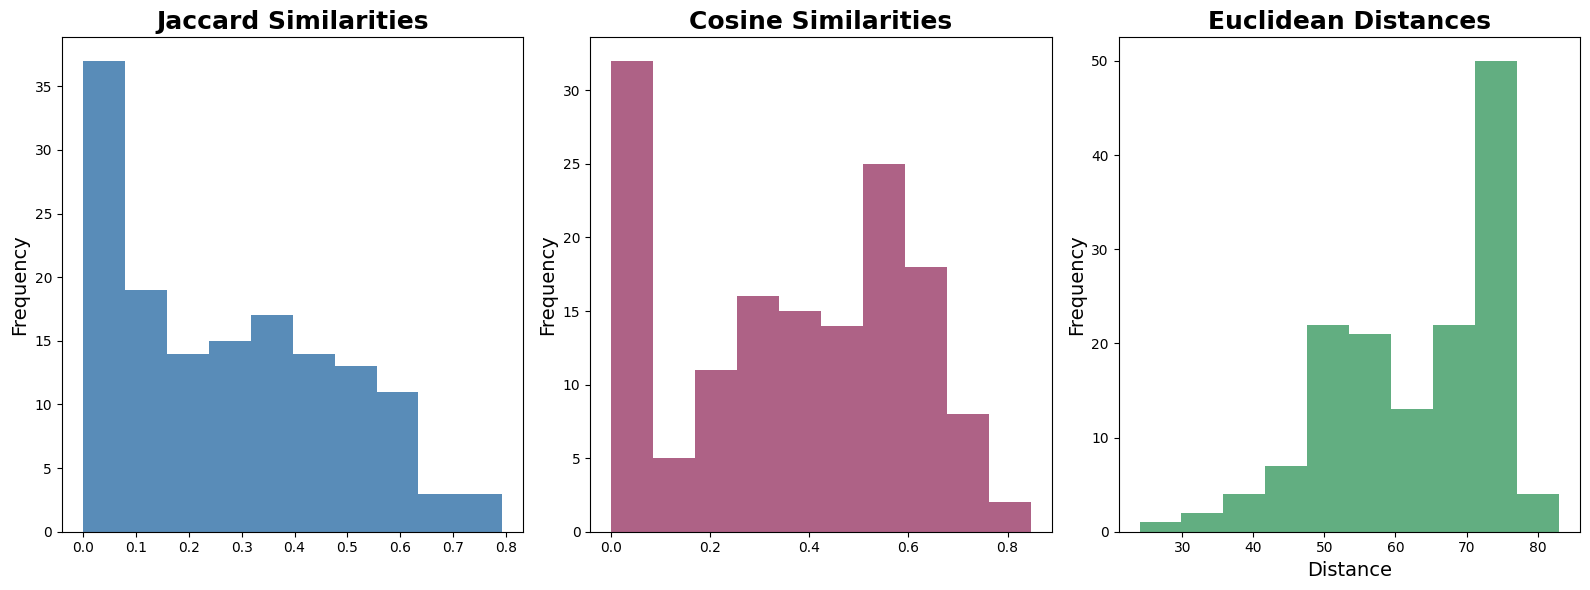

In [25]:
# find a node that has the highest betweenness closeness scoreW
highest_betweenness = max(tw_betweenness.items(), key=lambda k: k[1])
node, value = highest_betweenness[0], highest_betweenness[1]
# compute similarity scores
jaccard_similarities = compute_jaccard_similarity(graph=G_tw, node=node)
cosine_similarities = compute_cosine_similarity(graph=G_tw, node=node)
euclidean_dists = compute_euclidean_distance(graph=G_tw, node=node)
# plot distributions of the similarity scores
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].hist(jaccard_similarities, bins=10, color="#125b9a", alpha=0.7)
axs[0].set_title("Jaccard Similarities", fontsize=18, fontweight="bold")
axs[0].set_ylabel("Frequency", fontsize=14)
axs[1].hist(cosine_similarities, bins=10, color="#8c1f53", alpha=0.7)
axs[1].set_title("Cosine Similarities", fontsize=18, fontweight="bold")
axs[1].set_ylabel("Frequency", fontsize=14)
axs[2].hist(euclidean_dists, bins=10, color="#1f8c4c", alpha=0.7)
axs[2].set_title("Euclidean Distances", fontsize=18, fontweight="bold")
axs[2].set_xlabel("Distance", fontsize=14)
axs[2].set_ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()